In [4]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from collections import OrderedDict
from torch.autograd import Variable
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.utils.data

In [5]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def generateLatent(batch_size = 5,z_size = 200, noise=0.33):
    return Variable(torch.Tensor(batch_size, z_size).normal_(0, noise).cuda()).view(batch_size, z_size, 1,1,1)


In [6]:
# Creating a generator: Some latent vector to 3D voxel space 
# torch.nn.ConvTranspose3d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1)
# (Din−1)∗stride[0]−2∗padding[0]+kernel_size[0]+output_padding[0]

class generator(nn.Module):
    def __init__(self, z_size=200, cube_size=32):
        super(generator, self).__init__()
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.layer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        return out
        
        


In [7]:
# Conv3d: (in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
# input size (N,Cin,D,H,W) and output (N,Cout,Dout,Hout,Wout) 


class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.cube_len = 32
        self.leak_value = 0.2
        self.bias = False

        padd = (0,0,0)
        if self.cube_len == 32:
            padd = (1,1,1)
            
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv3d(1, self.cube_len, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len, self.cube_len*2, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*2),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*2, self.cube_len*4, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*4),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*4, self.cube_len*8, kernel_size=4, stride=2, bias=self.bias, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_len*8),
            torch.nn.LeakyReLU(self.leak_value)
        )
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv3d(self.cube_len*8, 1, kernel_size=4, stride=2, bias=self.bias, padding=padd),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        #print(x)
        out = x.view(-1, 1, self.cube_len, self.cube_len, self.cube_len)
#         print(out.size()) # torch.Size([100, 1, 32, 32, 32])
        out = self.layer1(out)
#         print(out.size())  # torch.Size([100, 32, 16, 16, 16])
        out = self.layer2(out)
#         print(out.size())  # torch.Size([100, 64, 8, 8, 8])
        out = self.layer3(out)
#         print(out.size())  # torch.Size([100, 128, 4, 4, 4])
        out = self.layer4(out)
#         print(out.size())  # torch.Size([100, 256, 2, 2, 2])
        out = self.layer5(out)
#         print(out.size())  # torch.Size([100, 1, 1, 1, 1])

        return out
        

In [22]:
#Training the system
num_epochs = 10
total_size = 5000
batch_size = 5
number_iterations = total_size / batch_size
voxels = np.load("voxels.npy")

train_loader = torch.utils.data.DataLoader(voxels, batch_size=5, shuffle=True, drop_last=True)

gen3d = generator()
gen3d.cuda()
dis3d = discriminator()
dis3d.cuda()
loss = nn.BCELoss()
D_solver = optim.Adam(dis3d.parameters(), lr=0.00005)
G_solver = optim.Adam(gen3d.parameters(), lr=0.0025)


for epoch in range(num_epochs):
    for batch_idx, data3d in enumerate(train_loader):
        real_labels = Variable(torch.ones(batch_size).cuda())
        fake_labels = Variable(torch.zeros(batch_size).cuda())
        real = Variable(data3d).cuda().float()
        
        #Discriminator loss
        z = generateLatent(batch_size=batch_size)
        fake = gen3d(z)
        fake_labels_pred = dis3d(fake)
        #print(Variable(data3d))
        real_labels_pred = dis3d(real)
        #print(real_labels_pred)
        loss_fake = loss(fake_labels_pred, fake_labels)
        loss_real = loss(real_labels_pred, real_labels)
        d_loss = loss_fake + loss_real
        d_real_acu = torch.ge(real_labels_pred.squeeze(), 0.5).float()
        d_fake_acu = torch.le(fake_labels_pred.squeeze(), 0.5).float()
        d_real_acu_mean = torch.mean(d_real_acu)
        d_fake_acu_mean = torch.mean(d_fake_acu)
        d_total_acu = torch.mean(torch.cat((d_real_acu, d_fake_acu),0))
        if d_total_acu<=0.8:
#         print(d_total_acu.data)
#         if d_total_acu <= 0.8:
            dis3d.zero_grad()
            d_loss.backward()
            D_solver.step()
        
        #Generator loss 
        z = generateLatent(batch_size=batch_size)
        fake = gen3d(z)
        d_fake = dis3d(fake)
        g_loss = loss(d_fake, real_labels)

        dis3d.zero_grad()
        gen3d.zero_grad()
        g_loss.backward()
        G_solver.step()
        
        #Printing
        if batch_idx%200 == 0:
            print("Epoch: ", epoch, " batch iteration: ", batch_idx, "D loss: ", d_loss.data.cpu().numpy(), " G loss: ", g_loss.data.cpu().numpy())
            print("Accuracy: ", d_total_acu.data.cpu().numpy(), " Real Acc: ", d_real_acu_mean.data.cpu().numpy(), " Fake Acc: ", d_fake_acu_mean.data.cpu().numpy())


C:\Users\adity\Anaconda3\envs\test\lib\site-packages\torch\nn\functional.py:1189: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


RuntimeError: bool value of Variable objects containing non-empty torch.cuda.ByteTensor is ambiguous

In [11]:
#Testing the Discriminator
voxels = np.load("voxels.npy")
print("Shape of the voxels", voxels.shape)
test_object = voxels[0]
print("Shape of the test object", test_object.shape)
dis3d = discriminator()
label = dis3d(Variable(torch.FloatTensor(test_object)))
print("Label value", label)

Shape of the voxels (100, 32, 32, 32)
Shape of the test object (32, 32, 32)
Label value Variable containing:
(0 ,0 ,0 ,.,.) = 
  0.4959
[torch.FloatTensor of size 1x1x1x1x1]



In [20]:
#Testing the Generator 
batch_size, z_size = 1, 200 
test_z = Variable(torch.Tensor(batch_size, z_size).normal_(0, 0.33).cuda()).view(batch_size, z_size, 1,1,1)
print("Print Latent State shape", test_z.shape)
gen3d = generator()
gen3d.cuda()
fake = gen3d(test_z)
print("Shape of the fake",fake.shape)
display3DObject(fake.squeeze().data.cpu().numpy()<0.5)

Print Latent State shape torch.Size([1, 200, 1, 1, 1])
Shape of the fake torch.Size([1, 1, 32, 32, 32])
Displaying the object


KeyboardInterrupt: 

Shape of the voxels (5000, 32, 32, 32)
Shape of the test object (32, 32, 32)


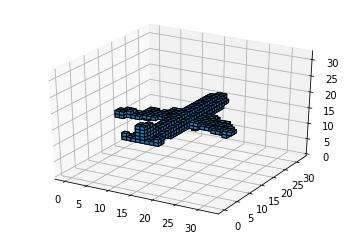

In [10]:
# Testing the Voxels
voxels = np.load("voxels.npy")
print("Shape of the voxels", voxels.shape)
test_object = voxels[0]
print("Shape of the test object", test_object.shape)

print("Displaying the object")
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(test_object, edgecolor='k')
plt.show()




